# <p><font size="4"><b> Runfile for the PixSWAB model</b></font></p>
> *2022*
> *By Solomon Seyoum*

This notebook can be used to run the Pixel Based Soil Water Balance model (PixSWAB).
The model has three required parameters namely base flow recession constant ***[0, 1]***, deep percolation constant ***[0, 1]*** and  runoff coefficient exponent ***[1, 5]***.
The model takes inputs of precipitation, actual evapotranspiration, interception, land cover classes and soil saturation content, soil filed capacity and soil texture classe and slope file. All the input files should be in **netCDF** format. The output of the model can include blue and green components of evapotranspiration, surface runoff and baseflow, soil mositure content and percoloation on monthly time step and all in **netCDF** format. 

#### Import packages

In [10]:
#import packages and soil moisture water balance function
%reload_ext autoreload
%autoreload 2
import xarray as xr
import rioxarray as rio
import numpy as np
import glob
import os
import pandas as pd
import sys
sys.path.insert(0, '../model')
import pixswab_v1 as pixswab
import hydroStats as hs
import datetime
# import yaml
import logging

# multiprocessing client
client = pixswab.start_multiprocessing()
client.restart()

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 7 Cores: 28 Memory: 119.11 GB


#### Prepare inputs for the model
##### The paths to the various input files, the model parameters and output types and and thier paths and the start and end date for the model run (which usually corresponds to the input files start and end date) should be specified in a config file.


In [4]:
# Read the config file
iniFile = r'..\config_files\pixswab_config.ini'

pixswab_inputs, pixswab_parameters, log_file_path, out_dir, encoding_output = pixswab.prepare_inputs(iniFile)

#### Run the model

In [6]:
result = pixswab.run_pixswab(pixswab_inputs, pixswab_parameters)

Start period 2009-01-01 00:00:00 
End period 2017-12-31 00:00:00
month:  108  of 108

#### Write the output  to netCDF files

In [7]:
pixswab.write_output_files(result, log_file_path, out_dir, encoding_output)

writing the netcdf files
* Surface_runoff
* Base_flow
Writing the netCDFs is completed!

It took 300.0501405 Secs to execute this method


In [16]:
chunks_size = encoding_output['chunksizes']
chunks = {'time':chunks_size[0],'latitude':chunks_size[1], 'longitude':chunks_size[2]}
basin_shp = r'..\..\Upper_Litani\input\shape\catchment_Upper_Litani_3s2_4326.shp'
    
outfiles = glob.glob(os.path.join(out_dir,'*.nc'))
bf_sr = [x for x in outfiles if 'Base_flow'  in x] + [x for x in outfiles if 'Surface_runoff' in x]
bf_sr.insert(0,pixswab_inputs['input_files']['p_in'])

data2convert = []
for fh in bf_sr:
    var,name = pixswab.open_nc(fh,chunks)
    data2convert.append(var)
    
df2 = pixswab.convert_result_to_volume(data2convert,basin_shp)
# read observed ourflw (discharge)
observed_discharge_file = r'..\..\Upper_Litani\input\observed_flow\discharge_Upper_Litani_JoubJannine_beforeQaraoun.csv'
Q_m=pd.read_csv(observed_discharge_file,sep=',',index_col=0)
Q_m.index = pd.to_datetime(Q_m.index)

# # combine the twi dataframes
df2 = df2[df2.index.isin(Q_m.index)]

df= pd.concat([df2, Q_m], axis =1)
# df = df.dropna()
idx = df.index

# compute evaluation criteria
warmupdays = 0
NSE = hs.NS(df['km3/month'],df['Base_flow'] + df['Surface_runoff'], warmupdays)
KGE = hs.KGE(df['km3/month'],df['Base_flow'] + df['Surface_runoff'], warmupdays)

### Plot time series

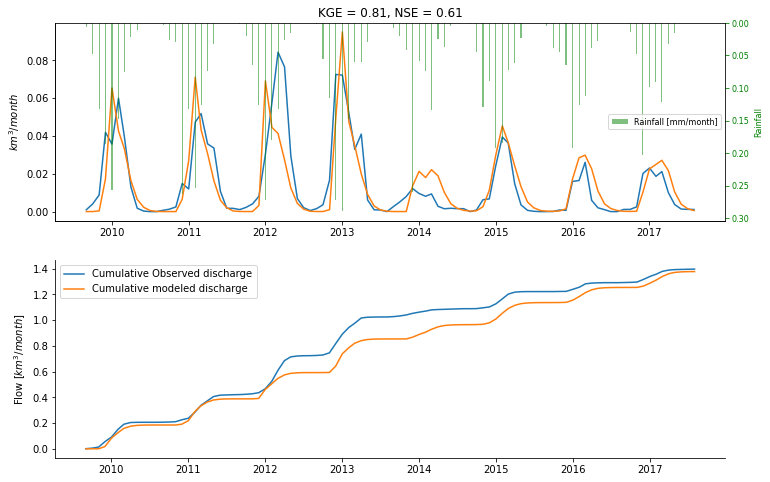

In [18]:
# Plot the resultss
import matplotlib.pyplot as plt


plt.figure(figsize=(12,8))
ax=plt.subplot(211)
ax.plot(df['km3/month'], label='Observed discharge at JoubJannine before Qaraoun')
ax.plot(idx, df['Base_flow'] + df['Surface_runoff'], label='Modeled discharge')
ax.set_ylabel('$km^3/month$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()
width = 5
#ax2.bar(x, y3[:,4]+y3[:,5],  width=width, color='g', label = "Rainfall")
# ax2.bar(df.index, df['Pcp_and_snow_release'],  width=width, color='g', label = "Rainfall [mm/month]",  alpha = 0.5)
ax2.bar(df.index, df['precipitation'],  width=width, color='g', label = "Rainfall [mm/month]",  alpha = 0.5)
ax2.set_ylabel('Rainfall', color='g',  fontsize=8)
ax2.tick_params('y', colors='g')
ax2.invert_yaxis()

plt.legend()
plt.title('KGE = {0:.2f}, NSE = {1:.2f}'.format(KGE,NSE))

ax=plt.subplot(212)
ax.plot(np.cumsum(df['km3/month']), label='Cumulative Observed discharge')
ax.plot(idx, np.cumsum(df['Base_flow'] + df['Surface_runoff']), label='Cumulative modeled discharge')

ax.set_ylabel('Flow [$km^3/month$]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# ax2.set_xlim(x[0], x[m-1]) 
# ax2.set_ylim(150, 0)
ax2.legend(loc='center right', fontsize=8)
ax2.tick_params(labelsize=8)

plt.legend()
plt.savefig(os.path.join(out_dir, 'Modeled_vs_observed_discharge.png'), bbox_inches='tight', dpi=600)
